Code to reproduce analysis for "Conflict-induced ship traffic disruptions constrain cloud sensitivity to stricter marine pollution regulations"
==

In [1]:
#Load libraries
import numpy as np
import xarray as xr
from scipy import stats
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from glob import glob

In [2]:
#Set directories
dir_figs = '/Users/michaeldiamond/Documents/Projects/ERB23_ShipTracks4MCB/Houthis/'
dir_data_no2 = '/Users/michaeldiamond/Documents/Data/TROPOMI/'
dir_data_nox = '/Users/michaeldiamond/Documents/Data/EDGAR/'
dir_data_viirs = '/Users/michaeldiamond/Documents/Projects/ERB23_ShipTracks4MCB/ShipClosure/Results/'
dir_data_tracks = '/Users/michaeldiamond/Documents/Data/UNet_Ship_Tracks/'

Process TROPOMI NO$_2$ columns
=

In [3]:
#Set domain for NO2 analysis
lon0 = -13.5
lon1 = 3.5
lat0 = -15
lat1 = 0

In [4]:
#Load TROPOMI data
no2 = xr.open_dataset(dir_data_no2+'no2_temis_201809-202410.nc')['NO2']
no2 = no2.where(no2>0,np.nan) #NaN invalid data

In [5]:
#Load EDGAR data
edgar = xr.open_dataset(dir_data_nox+'v8.1_FT2022_AP_NOx_2019_TNR_Ship_flx.nc')

#Interpolate to TROPOMI resolution
new_lat=np.arange(lat0+.125/2,lat1,.125)
new_lon=np.arange(lon0+.125/2,lon1,.125)
nox_int = edgar['fluxes'].sel(lat=slice(lat0,lat1),lon=slice(lon0,lon1)).interp(lat=new_lat,lon=new_lon)

In [6]:
#Create shipping corridor mask
ship_no2 = np.zeros((len(no2.lat),len(no2.lon)))

#At each latitude, find the longitude with the maximum value
lon_mask = np.logical_and(no2.lon>lon0,no2.lon<lon1)
for lat in nox_int.lat.values:
    ship_no2[no2.lat.values==lat,lon_mask] = nox_int.sel(lat=lat)==nox_int.sel(lat=lat).max(dim=['lon'])
    
#Crop to domain
shipmask = ship_no2[np.logical_and(no2.lat>lat0,no2.lat<lat1)][:,lon_mask]

Text(0.5, 0, 'Longitude (degrees E)')

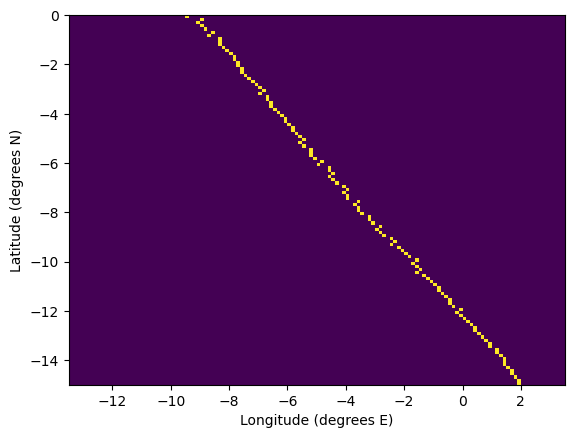

In [7]:
#Check locations
plt.pcolormesh(new_lon,new_lat,shipmask)
plt.ylabel('Latitude (degrees N)')
plt.xlabel('Longitude (degrees E)')

In [8]:
#Set up dataset to store NO2 perturbation data
xN = xr.Dataset()
xN['time'] = no2.time
xN['lon'] = np.arange(-4.9375,5,.125) #5 degrees of longitude on either side of central corridor
xN['no2'] = (['time','lon'],np.nan*np.ones((len(xN.time),len(xN.lon))))
xN['no2_err'] = (['time','lon'],np.nan*np.ones((len(xN.time),len(xN.lon))))

In [9]:
#Fill in data
for i in range(len(xN.time)):
    for j in range(len(xN.lon)):
        dlon = xN.lon[j]
        x_ = (shipmask*no2[i].sel(lat=slice(lat0,lat1),lon=slice(lon0+dlon,lon1+dlon-.125/2)))
        x = np.array(x_)[np.array(x_)!=0]
        x[x<0] = np.nan
        xerr = np.nanstd(x,ddof=1)/np.sqrt(len(x))
        xN['no2'][i,j] = np.nanmean(x)
        xN['no2_err'][i,j] = xerr

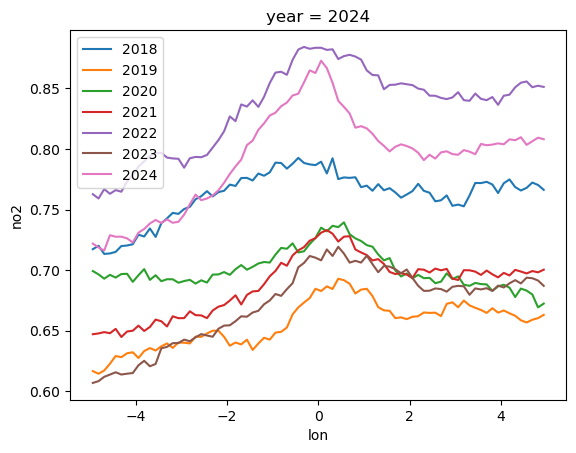

In [10]:
#Check raw values
data = xN['no2'].groupby('time.year').mean()
for i in range(7):
    data[i].plot(label=data[i].year.values)
plt.legend()

In [11]:
#Calculate NO2 perturbation
xN['year'] = np.arange(2018,2024+1)
xN['slope'] = (['year'],np.nan*np.ones(len(xN.year)))
xN['intercept'] = (['year'],np.nan*np.ones(len(xN.year)))
xN['RMSE'] = (['year'],np.nan*np.ones(len(xN.year)))
xN['dNO2'] = (['year'],np.nan*np.ones(len(xN.year)))

for i in range(len(xN.year)):
    
    #Regressions
    year = xN.year[i].values
    data = xN['no2'].groupby('time.year').mean()[i]
    y = np.array(data[np.logical_or(data.lon>2,data.lon<-2)])
    x = np.array(data.lon[np.logical_or(data.lon>2,data.lon<-2)])
    slope = np.sum((y-y.mean())*(x-x.mean()))/np.sum((x-x.mean())**2)
    intercept = y.mean() - slope*x.mean()
    xN['slope'][i] = slope
    xN['intercept'][i] = intercept
    
    #RMS error
    yhat = intercept+slope*x
    xN['RMSE'][i] = np.sqrt(np.mean((y-yhat)**2))
    
    #Anomaly within +/- 0.25 degree of central corridor
    xship = data.lon.sel(lon=slice(-.25,.25))
    yship = data.sel(lon=slice(-.25,.25))
    yest =  intercept+slope*xship
    dNO2 = np.mean(yship-yest)
    
    xN['dNO2'][i] = dNO2

#Propagated error from calculating mean +/- 0.25 degree of central corridor
err0 = np.array([np.sqrt(((xN['no2_err'][xN.time.dt.year==year].sel(lon=slice(-.25,.25)))**2).sum())/8 for year in xN.year.values])

#Combined error for subtracting regressed values from mean
xN['error'] = (['year'],np.sqrt(err0**2+xN['RMSE']**2).values)

Text(0.5, 0, 'Degrees away from maximum NOx emissions')

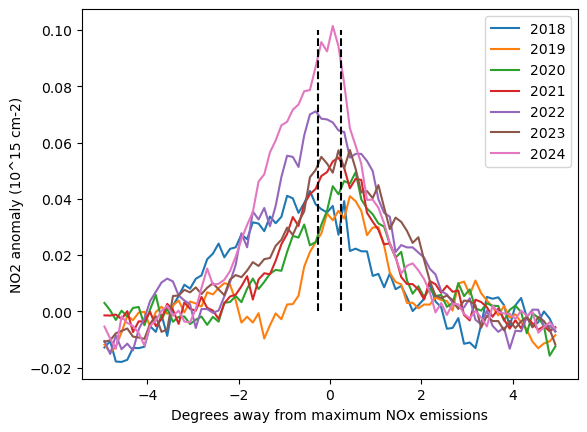

In [12]:
#Check regressions
for i in range(len(xN.year)):
    year = xN.year[i].values
    plt.plot(xN.lon,xN['no2'].groupby('time.year').mean()[i]-(xN.intercept[i]+xN.slope[i]*xN.lon),label=year)
plt.legend()
plt.plot([-.25,-.25],[0,.1],'k--')
plt.plot([.25,.25],[0,.1],'k--')
plt.ylabel('NO2 anomaly (10^15 cm-2)')
plt.xlabel('Degrees away from maximum NOx emissions')

Text(0, 0.5, 'NO2 anomaly (10^15 cm-2)')

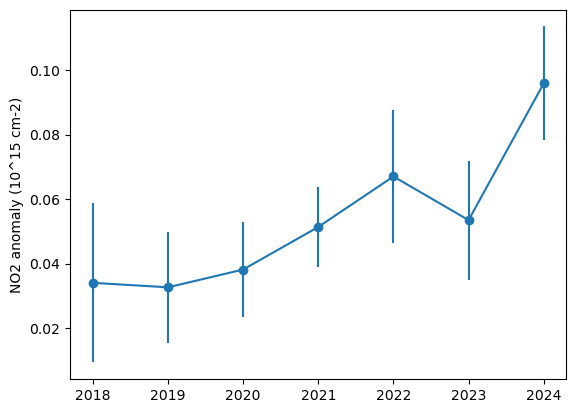

In [13]:
#Check anomaly values
plt.errorbar(xN.year,xN['dNO2'],yerr=2*xN['error'],marker='o')
plt.ylabel('NO2 anomaly (10^15 cm-2)')

Text(0, 0.5, 'dln[NO2] (%)')

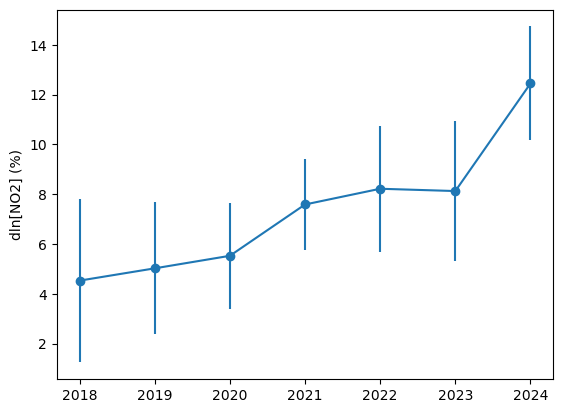

In [14]:
#Check relative anomaly values
plt.errorbar(xN.year,100*xN['dNO2']/xN['intercept'],yerr=2*100*xN['error']/xN['intercept'],marker='o')
plt.ylabel('dln[NO2] (%)')

Figure 1: TROPOMI NO$_2$ columns
=

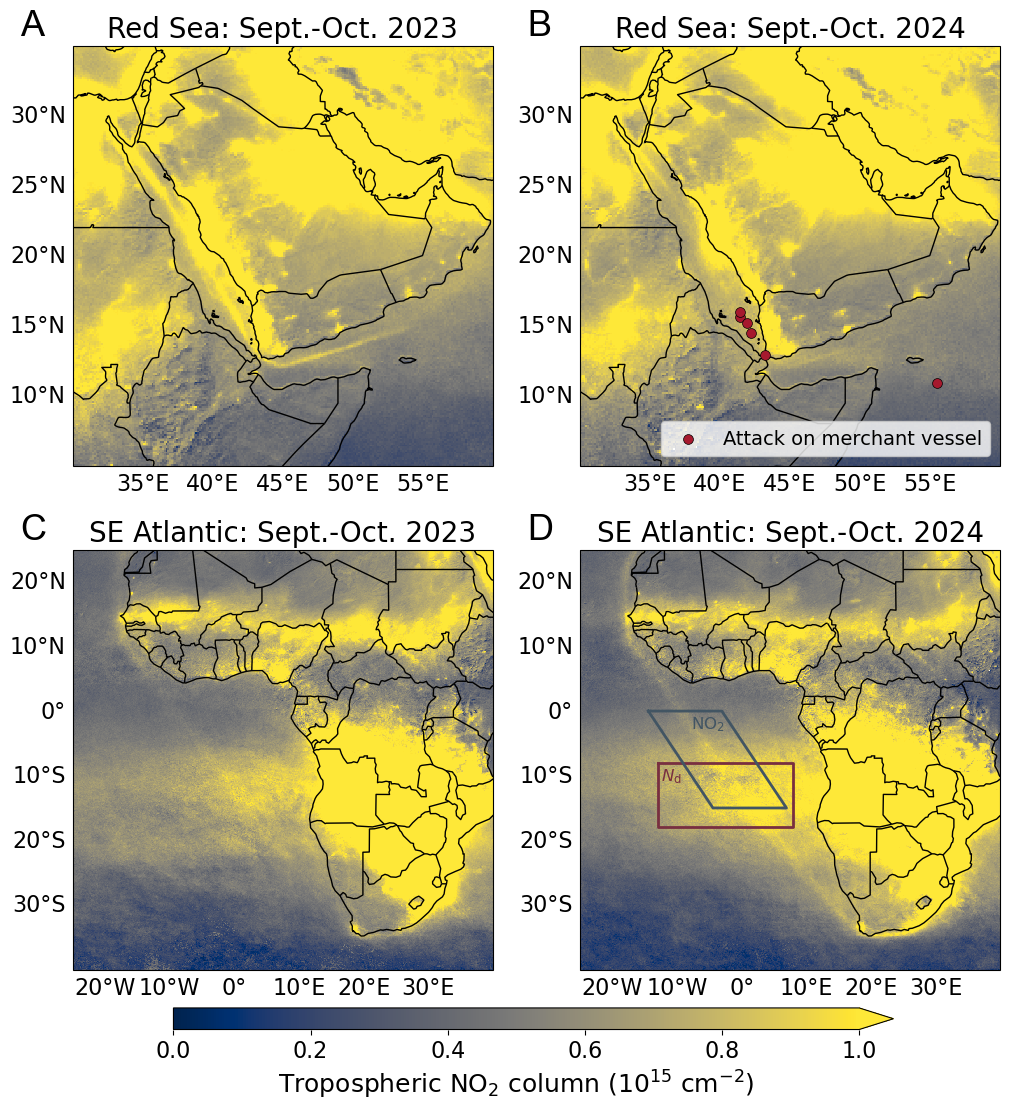

In [15]:
#Map base
plt.figure(figsize=(12,12))
plt.clf()
fs = 20

#
###TROPOMI of SEA
#
lt0, lt1, ln0, ln1 = -25,40,-40,25

#2023

ax = plt.subplot(223, projection=ccrs.PlateCarree())
ax.set_extent([lt0, lt1, ln0, ln1],crs=ccrs.PlateCarree())
ax.coastlines(color='k',lw=1,zorder=10)
ax.add_feature(cartopy.feature.BORDERS,edgecolor='k',lw=1,zorder=5)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='.5', alpha=0,zorder=9)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': fs-4}
gl.ylabel_style = {'size': fs-4}
gl.yformatter = LatitudeFormatter(degree_symbol='°')
gl.xformatter = LongitudeFormatter(degree_symbol='°')

data = no2.sel(lat=slice(-45,45),lon=slice(-90,90)).groupby('time.year').mean()[-2]
ax.pcolormesh(data.lon,data.lat,data,vmin=0,vmax=1,transform=ccrs.PlateCarree(),cmap='cividis')

plt.title('SE Atlantic: Sept.-Oct. 2023',fontsize=fs)

ax.text(-.125,1.025,s='C',transform = ax.transAxes,fontsize=fs+6,fontname='Arial')

#2024

ax = plt.subplot(224, projection=ccrs.PlateCarree())
ax.set_extent([lt0, lt1, ln0, ln1],crs=ccrs.PlateCarree())
ax.coastlines(color='k',lw=1,zorder=10)
ax.add_feature(cartopy.feature.BORDERS,edgecolor='k',lw=1,zorder=10)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='.5', alpha=0,zorder=9)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': fs-4}
gl.ylabel_style = {'size': fs-4}
gl.yformatter = LatitudeFormatter(degree_symbol='°')
gl.xformatter = LongitudeFormatter(degree_symbol='°')

data = no2.sel(lat=slice(-45,45),lon=slice(-90,90)).groupby('time.year').mean()[-1]
ax.pcolormesh(data.lon,data.lat,data,vmin=0,vmax=1,transform=ccrs.PlateCarree(),cmap='cividis')

#Nd box
plt.plot([-13,8,8,-13,-13],[-8,-8,-18,-18,-8],c='#782F40',lw=2,transform=ccrs.PlateCarree())
plt.text(-13+.5,-8-.5,r'$N_\mathrm{d}$',fontsize=fs-8,color='#782F40',transform=ccrs.PlateCarree(),va='top',ha='left')

#NO2 box
lonmax = (shipmask[0]*no2.lon.sel(lon=slice(lon0,lon1-.125/2))).max()
lonmin = (shipmask[-1]*no2.lon.sel(lon=slice(lon0,lon1-.125/2))).min()

plt.plot([lonmin-5,lonmax-5,lonmax+5,lonmin+5,lonmin-5],[0,0,-15,-15,0],c='#425563',lw=2,transform=ccrs.PlateCarree())
plt.text(lonmax-5+.5,0-.5,r'$\mathrm{NO}_2$',fontsize=fs-8,color='#425563',transform=ccrs.PlateCarree(),va='top',ha='right')

plt.title('SE Atlantic: Sept.-Oct. 2024',fontsize=fs)

ax.text(-.125,1.025,s='D',transform = ax.transAxes,fontsize=fs+6,fontname='Arial')


#
###TROPOMI of Red Sea
#

#2023

ax = plt.subplot(221, projection=ccrs.PlateCarree())
ax.set_extent([30,60,5,35],crs=ccrs.PlateCarree())
ax.coastlines(color='k',lw=1,zorder=10)
ax.add_feature(cartopy.feature.BORDERS,edgecolor='k',lw=1,zorder=10)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='.5', alpha=0,zorder=9)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': fs-4}
gl.ylabel_style = {'size': fs-4}
gl.yformatter = LatitudeFormatter(degree_symbol='°')
gl.xformatter = LongitudeFormatter(degree_symbol='°')

data = no2.sel(lat=slice(5,35),lon=slice(30,60)).groupby('time.year').mean()[-2]
ax.pcolormesh(data.lon,data.lat,data,vmin=0,vmax=1,transform=ccrs.PlateCarree(),cmap='cividis')

plt.title('Red Sea: Sept.-Oct. 2023',fontsize=fs)

ax.text(-.125,1.025,s='A',transform = ax.transAxes,fontsize=fs+6,fontname='Arial')

#2024

ax = plt.subplot(222, projection=ccrs.PlateCarree())
ax.set_extent([30,60,5,35],crs=ccrs.PlateCarree())
ax.coastlines(color='k',lw=1,zorder=2)
ax.add_feature(cartopy.feature.BORDERS,edgecolor='k',lw=1,zorder=2)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='.5', alpha=0,zorder=9)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {'size': fs-4}
gl.ylabel_style = {'size': fs-4}
gl.yformatter = LatitudeFormatter(degree_symbol='°')
gl.xformatter = LongitudeFormatter(degree_symbol='°')

data = no2.sel(lat=slice(5,35),lon=slice(30,60)).groupby('time.year').mean()[-1]
ax.pcolormesh(data.lon,data.lat,data,vmin=0,vmax=1,transform=ccrs.PlateCarree(),cmap='cividis',zorder=0)

sz = 50
ax.scatter(41.45,15.6,marker='o',edgecolors='k',lw=.5,color='#A6192E',s=sz,transform=ccrs.PlateCarree(),zorder=11,label='Attack on merchant vessel') #09/02/2024: Blue Lagoon I/Amjad oil tankers
ax.scatter(41.4,16,marker='o',edgecolors='k',lw=.5,color='#A6192E',s=sz,transform=ccrs.PlateCarree(),zorder=11) #10/01/2024: Minoan Courage container ship
ax.scatter(41.9,15.2,marker='o',edgecolors='k',lw=.5,color='#A6192E',s=sz,transform=ccrs.PlateCarree(),zorder=11) #10/01/2024: Cordelia Moon crude oil ship
ax.scatter(42.2,14.5,marker='o',edgecolors='k',lw=.5,color='#A6192E',s=sz,transform=ccrs.PlateCarree(),zorder=11) #10/09/2024: Olympic Spirit chemical/oil products tanker
ax.scatter(55.5,10.9,marker='o',edgecolors='k',lw=.5,color='#A6192E',s=sz,transform=ccrs.PlateCarree()) #10/18/2024: Megalopolis container ship
ax.scatter(43.2,12.9,marker='o',edgecolors='k',lw=.5,color='#A6192E',s=sz,transform=ccrs.PlateCarree(),zorder=11) #10/28/2024: Maersk Kowloon and SC Montreal container ships

plt.legend(fontsize=fs-6,loc='lower right',framealpha=.8)

plt.title('Red Sea: Sept.-Oct. 2024',fontsize=fs)

ax.text(-.125,1.025,s='B',transform = ax.transAxes,fontsize=fs+6,fontname='Arial')

# Add colorbar
cb_ax = plt.axes([0.21, 0.06, 0.6, 0.018])  # [left, bottom, width, height]
shading = ax.pcolormesh(data.lon[::10],data.lat[::10],np.nan*data[::10,::10],vmin=0,vmax=1,cmap='cividis',transform=ccrs.PlateCarree(),zorder=-1)
cbar = plt.colorbar(shading, cax=cb_ax, orientation='horizontal',extend='max')
cbar.set_label(r'Tropospheric $\mathrm{NO}_2$ column ($10^{15}$ $\mathrm{cm}^{-2}$)',fontsize=fs-2)
cbar.ax.tick_params(labelsize=fs-4)

plt.savefig(dir_figs+'Fig1.png',dpi=450,transparent=False)
plt.show()

Process NOAA-20/VIIRS $N_\mathrm{d}$ data
==

In [16]:
#Load NOAA-20/VIIRS data
ylist20 = np.arange(2018,2024+1)
ds20 = {y : xr.open_dataset(dir_data_viirs+f'Data_NOAA20_Nad_{y}_Cx_M9to10.nc') for y in ylist20}

In [17]:
#Extract useful information
trk = np.zeros(90,dtype=bool)
trk[4::9] = True
trk[5::9] = True ##Central track only
trk[6::9] = True

In [18]:
#Calculate "core" shipping corridor differences
dN20 = {y : (ds20[y]['shipObs']-ds20[y]['krSims'])[trk].mean().values for y in ylist20}
dO20 = {y : (ds20[y]['shipObs'])[trk].mean().values for y in ylist20}
dlnN20 = {y : (100*(ds20[y]['shipObs']-ds20[y]['krSims'])/ds20[y]['shipObs'])[trk].mean(dim=['ship_dim']).values for y in ylist20}

Text(0, 0.5, 'dNd (cm-3)')

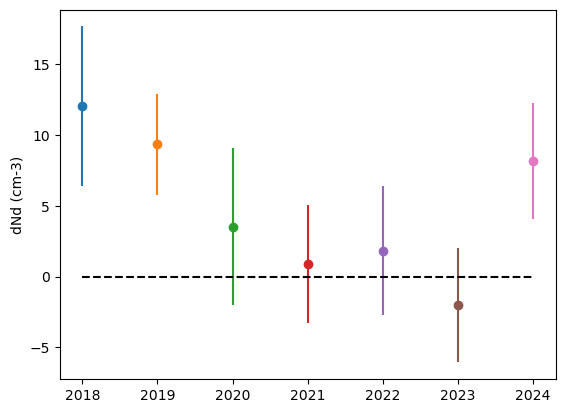

In [19]:
#Check absolute difference values
for key in dlnN20.keys():
    plt.errorbar(key,dN20[key].mean(),yerr=2*(ds20[key]['shipObs']-ds20[key]['krSims'])[trk].mean(dim='ship_dim').std().values,marker='o')
plt.plot([2018,2024],[0,0],'k--')
plt.ylabel('dNd (cm-3)')

Text(0, 0.5, 'dlnNd (%)')

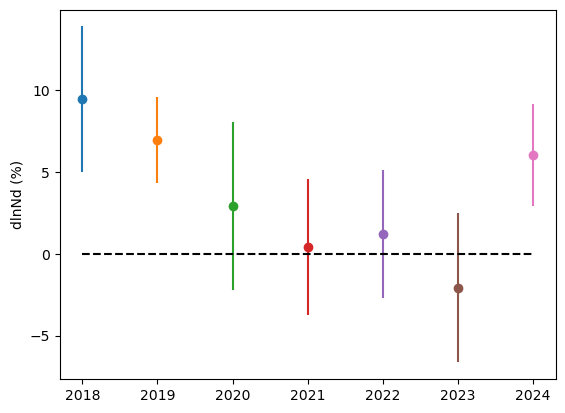

In [20]:
#Check relative difference values
for key in dlnN20.keys():
    plt.errorbar(key,dlnN20[key].mean(),yerr=2*dlnN20[key].std(),marker='o')
plt.plot([2018,2024],[0,0],'k--')
plt.ylabel('dlnNd (%)')

Figure 2: Violin plots of shipping anomalies and their ratio
=

In [21]:
#First subplot: dln(NO2)
V1 = np.array([np.random.normal((100*xN['dNO2']/xN['intercept']).sel(year=y).values,(100*xN['error']/xN['intercept']).sel(year=y).values,5000) for y in ylist20])
v1 = [xx[np.logical_and(xx<np.percentile(xx,97.5),xx>np.percentile(xx,2.5))] for xx in V1] #95% CI

In [22]:
#Second subplot: dln(Nd)
V2 = np.array([dlnN20[y] for y in ylist20])
v2 = [xx[np.logical_and(xx<np.percentile(xx,97.5),xx>np.percentile(xx,2.5))] for xx in V2] #95% CI

In [23]:
#Third subplot: dlnNd/dln[NO2]
V3 = np.array(V2/V1)
v3 = [xx[np.logical_and(xx<np.percentile(xx,97.5),xx>np.percentile(xx,2.5))] for xx in V3] #95% CI

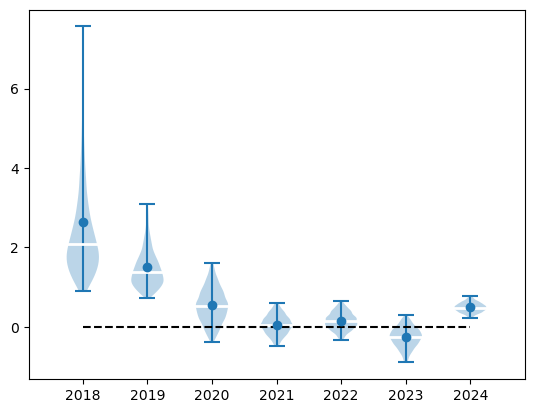

In [24]:
#Check ratios
plt.violinplot(v3,ylist20)
for i in range(len(ylist20)):
    plt.plot([ylist20[i]-.49,ylist20[i]+.49],2*[np.percentile(V3[i],50)],lw=2,c='w')
plt.scatter(ylist20,[v.mean() for v in V3],zorder=10)
plt.plot([2018,2024],[0,0],'k--')

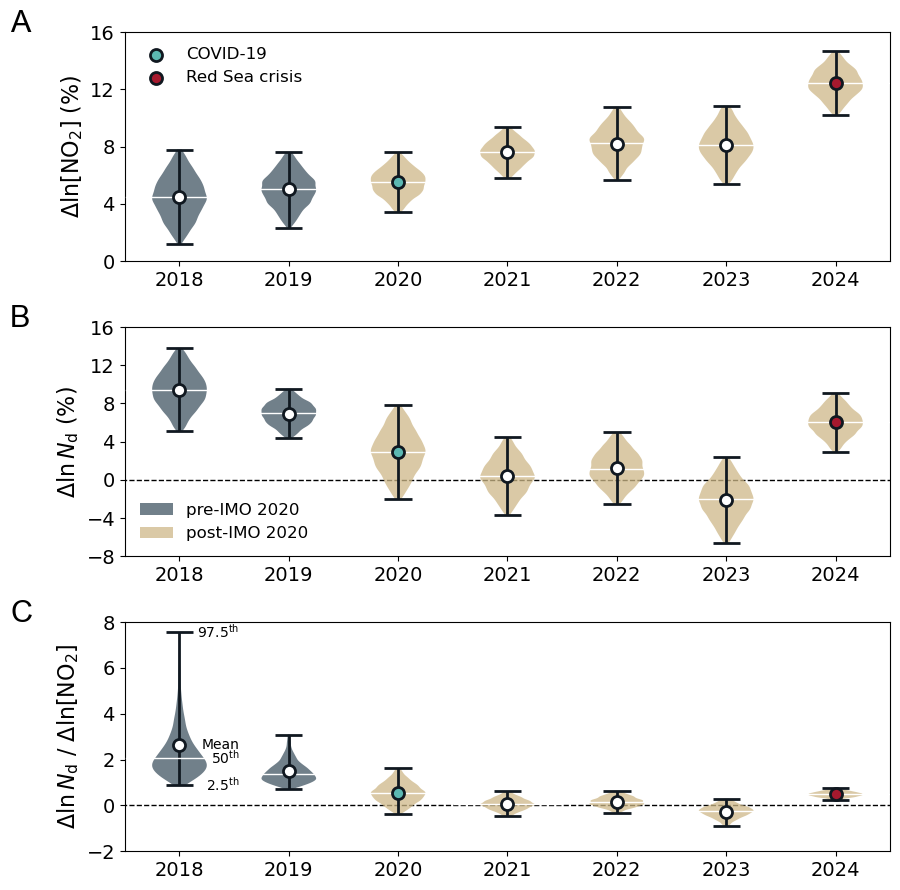

In [25]:
#Figure
plt.figure(figsize=(9,9))
fs = 16

vcolors = 2*['#425563']+5*['#CEB888']
mcolors = 2*['#FFFFFF']+['#5CB8B2']+3*['#FFFFFF']+['#A6192E']

for n, vdata, Vdata in zip([1,2,3],[v1,v2,v3],[V1,V2,V3]):
    plt.subplot(3,1,n)

    vplot = plt.violinplot(vdata,ylist20)
    
    #Shading
    for pc, vcolor in zip(vplot['bodies'],vcolors):
        pc.set_facecolor(vcolor)
        pc.set_alpha(.75)
        
    #Lines
    for partname in ('cbars', 'cmins', 'cmaxes'):
        vp = vplot[partname]
        vp.set_edgecolor('#101820')
        vp.set_linewidth(2)
    
    #Median
    for x, y, mcolor in zip(ylist20,[np.percentile(V,50) for V in Vdata],mcolors):
        plt.plot([x-.49,x+.49],2*[y],color='w',lw=1,zorder=9)
    
    #Mean
    for x, y, mcolor in zip(ylist20,[V.mean() for V in Vdata],mcolors):
        plt.scatter(x,y,s=75,zorder=10,edgecolor='#101820',lw=2,color=mcolor)
        
#dln[NO2]
ax1 = plt.subplot(3,1,1)
plt.ylim(0,16)
plt.xlim(2017.5,2024.5)
plt.yticks(np.arange(0,16+1,4),fontsize=fs-2)
plt.ylabel(r'$\Delta \ln [\mathrm{NO}_2]$ (%)',fontsize=fs)
plt.xticks(fontsize=fs-2)
plt.scatter(np.nan,np.nan,s=75,zorder=10,edgecolor='#101820',lw=2,color=mcolors[2],label='COVID-19')
plt.scatter(np.nan,np.nan,s=75,zorder=10,edgecolor='#101820',lw=2,color=mcolors[-1],label='Red Sea crisis')

ax1.text(-.15,1,s='A',transform = ax1.transAxes,fontsize=fs+6,fontname='Arial')

plt.legend(frameon=False,fontsize=fs-4)

ax2 = plt.subplot(3,1,2)
plt.plot([2017,2025],[0,0],'k--',lw=1,zorder=0)
plt.ylim(-8,16)
plt.xlim(2017.5,2024.5)
plt.yticks(np.arange(-8,16+1,4),fontsize=fs-2)
plt.ylabel(r'$\Delta \ln N_\mathrm{d}$ (%)',fontsize=fs)
plt.xticks(fontsize=fs-2)
plt.fill_between(2*[np.nan],2*[np.nan],2*[np.nan],facecolor=vcolors[0],label='pre-IMO 2020',alpha=.75)
plt.fill_between(2*[np.nan],2*[np.nan],2*[np.nan],facecolor=vcolors[-1],label='post-IMO 2020',alpha=.75)
plt.legend(frameon=False,fontsize=fs-4,loc=3)
ax2.text(-.15,1,s='B',transform = ax2.transAxes,fontsize=fs+6,fontname='Arial')

ax3 = plt.subplot(3,1,3)

#Add text to show 2.5, 50, 97.5 percentiles and mean
plt.text(2018.55,np.percentile(V3[0],2.5),r'2.5$^\mathrm{th}$',ha='right',va='center',fontsize=fs-6)
plt.text(2018.55,np.percentile(V3[0],97.5),r'97.5$^\mathrm{th}$',ha='right',va='center',fontsize=fs-6)
plt.text(2018.55,np.percentile(V3[0],50),r'50$^\mathrm{th}$',ha='right',va='center',fontsize=fs-6,zorder=12)
plt.text(2018.55,np.mean(V3[0]),'Mean',ha='right',va='center',fontsize=fs-6)

plt.plot([2017,2025],[0,0],'k--',lw=1,zorder=0)
plt.ylim(-2,8)
plt.xlim(2017.5,2024.5)
plt.yticks(np.arange(-2,8+1,2),fontsize=fs-2)
plt.ylabel(r'$\Delta \ln N_\mathrm{d}$ / $\Delta \ln [\mathrm{NO}_2]$',fontsize=fs)
plt.xticks(fontsize=fs-2)
plt.fill_between(2*[np.nan],2*[np.nan],2*[np.nan],facecolor=vcolors[0],label='pre-IMO 2020',alpha=.75)
plt.fill_between(2*[np.nan],2*[np.nan],2*[np.nan],facecolor=vcolors[-1],label='post-IMO 2020',alpha=.75)
ax3.text(-.15,1,s='C',transform = ax3.transAxes,fontsize=fs+6,fontname='Arial')

plt.tight_layout()

plt.savefig(dir_figs+'Fig2.png',dpi=450,transparent=False)
plt.savefig(dir_figs+'Fig2.pdf')

plt.show()

In [26]:
#Sensitivity range
np.percentile(1-V3[-1]/V3[1],[2.5,50,97.5])

array([0.22511441, 0.65527483, 0.88515326])

In [27]:
#Sulfur-relative sensitivity range
np.percentile(1-V3[-1]/V3[1],[2.5,50,97.5])/.8

array([0.28139301, 0.81909353, 1.10644158])

Comparison with Yuan et al. (2022) ship tracks
=

In [28]:
#Load ship track data
trks = xr.open_dataset(dir_data_tracks+'2003-2020_datetimes_lats_lons_of_shiptracks_60S-60N-1.nc')

In [29]:
#Set location mask
SEA_lat = np.logical_and(trks.lat_mean<=-8,trks.lat_mean>=-18)
SEA_lon = np.logical_and(trks.lon_mean<=8,trks.lon_mean>=-13)
SEA = np.logical_and(SEA_lat,SEA_lon)

In [30]:
#Get only ship tracks within SEA box
date_ = np.array(trks.date_doy)
time_utc_ = np.array(trks.time_utc)
date = date_[SEA]
time_utc = time_utc_[SEA]

In [31]:
#Create datetime variable
stdt = []
for i in range(len(date)):
    year = int(date[i][:4])
    doy = int(date[i][-3:])
    hour = int(time_utc[i][:2])
    minute = int(time_utc[i][2:])
    
    dt = np.datetime64(f"{year}-01-01T12:00") + np.timedelta64(doy - 1, 'D') + np.timedelta64(hour,'h') + np.timedelta64(minute,'m')
    stdt.append(dt)
ds = xr.Dataset()
ds['time'] = stdt

/var/folders/hm/sjqx2ddn4kggwkh2f7dnpk100000gn/T/ipykernel_27237/2645608423.py:12: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  ds['time'] = stdt
/var/folders/hm/sjqx2ddn4kggwkh2f7dnpk100000gn/T/ipykernel_27237/2645608423.py:12: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable co

In [32]:
#Count number of tracks in region for each year for September and October
month_mask = np.logical_or(ds['time'].dt.month==9,ds['time'].dt.month==10)
counts = [len(ds['time'][np.logical_and(month_mask,ds['time'].dt.year==y)]) for y in range(2003,2020+1)]

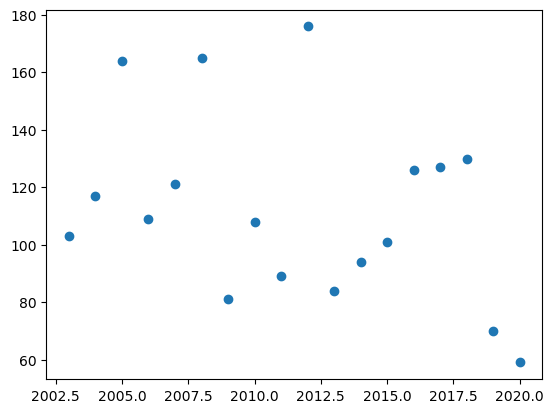

In [33]:
#Visualize counts
plt.scatter(range(2003,2020+1),counts)

In [34]:
#Mean and standard error for pre-2020 values
trk_mean = np.mean(counts[:-1])
trk_s = np.std(counts[:-1],ddof=1)/np.sqrt(len(counts[:-1]))
print(f'Mean: {trk_mean:.1f}, 95% CI: {2*trk_s:.1f}')

Mean: 115.6, 95% CI: 14.8


In [35]:
#Mean for 2020
counts[-1]

59

In [36]:
#Sensitivity
trk_imo = (1-counts[-1]/trk_mean)
trk_imo_err = counts[-1]/trk_mean**2*trk_s
print(f'Sensitivity mean: {trk_imo*100:.1f}%, 95% CI: {2*trk_imo_err*100/.8:.1f}%')

Sensitivity mean: 49.0%, 95% CI: 8.2%


In [37]:
#Relative sensitivity
trk_imo/.8

0.6119592875318066